#Version changes




Added some basic charts with groupby function

Updated to include dictionaries that hold the information for the 'types' [Project],[Chargeable Expense],[Expense],[Internal]
Also , readjust the filename for the source column

changed the upload of data function to work instead with google drive folder, which must be named TimesheetStaging.

# Upload the files

In [1]:
import glob
from google.colab import files
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

#!ls "/gdrive/My Drive/"

uploaded = glob.glob(f"/gdrive/My Drive/TimesheetStaging/*.xlsm")
for file in uploaded:  
  print('hello',file)

Mounted at /gdrive
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_kab_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_hem_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_mur_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_WAB_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_ATS_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_BED_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_HOA_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_bif_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_BIG_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_VOM_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_zit_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_tsr_202212.xlsm
hello /gdrive/My Drive/TimesheetStaging/asubium_timesheet_spr_202212.xlsm
hello /gdrive/My Dr

# The code

<h2>This is the workhorse i.e. code that scraps the files for the data required.

import is a term that for python to know which libraries to use, pandy is like an Excel sheet on crack. Numpy has some cool constructs like time series , etc etc

In [2]:
import pandas as pd
import numpy as np

Here I instantiate some variables (not normally necessary but Googles version of a notebook somehow needs it, and I also define the internal projects based on the excel spreadsheet.

In [3]:
df = pd.DataFrame()
theYear = ''
theMonth = ''
initials = ''
filename = ''

columnDays = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']
columnExcel = ['name','total'] + columnDays

this is the part where I get the details wrangled and ready to look at. 

In [4]:
for f in uploaded:
    #The filename should be 'asubium_timesheets_xxx_yyyymm.xl*+'
    filename = f.split("\\")[-1]
    filename = filename.replace(r'/gdrive/My Drive/TimesheetStaging/','',1)
    initials = filename.split("_")[2]
    theYear = filename.split("_")[3][0:4]
    theMonth = filename.split("_")[3][4:6]

    print ('start parsing        ', filename )
    d =  pd.read_excel(f, skiprows = 8, usecols = 'D:AJ', header=None, names=columnExcel)
    filename = f.split("\\")[-1]
    filename = filename.replace(r'/gdrive/My Drive/TimesheetStaging/','',1)
    initials = filename.split("_")[2]
    theYear = filename.split("_")[3][0:4]
    theMonth = filename.split("_")[3][4:6]

    d['Type'] =''
    total_chargeable_start =  d.index[d['name'] == 'Total Chargeable'].tolist()[0] 
    total_chargeable_end = d.index[d['name'] == 'Total Internal'].tolist()[0]  - d.index[d['name'] == 'Total Chargeable'].tolist()[0] 

    total_internal_start =  d.index[d['name'] == 'Total Internal'].tolist()[0] 
    total_internal_end = d.index[d['name'] == 'Chargeable Expenses'].tolist()[0] 

    total_chargeable_expenses_start =  d.index[d['name'] == 'Chargeable Expenses'].tolist()[0] 
    total_chargeable_expenses_end = d.index[d['name'] == 'Expenses'].tolist()[0] 

    total_expenses_start =  d.index[d['name'] == 'Expenses'].tolist()[0] 
    total_expenses_end = 100 - d.index[d['name'] == 'Expenses'].tolist()[0]

    d.iloc[total_chargeable_start:total_chargeable_end].Type = 'chargeable'
    d.iloc[total_internal_start:total_internal_end].Type = 'internal'
    d.iloc[total_chargeable_expenses_start:total_chargeable_expenses_end].Type = 'chargeable_expense'
    d.iloc[total_expenses_start:total_expenses_end].Type = 'expense'


    e = pd.melt(d.reset_index(), id_vars =['name'], value_vars =columnDays)
    f = pd.melt(d.reset_index(), id_vars =['Type'], value_vars =columnDays)
    del f['variable']
    del f['value']


    g = pd.concat([e, f], axis=1)
    g.replace(0, np.nan, inplace=True)
    g = g.drop_duplicates()
    g = g.rename(columns={'variable': 'Date', 'value': 'Value','name':'Category'})
    g['Emp'] = initials.upper()
    g['Comment'] = ''
    g['Source'] = filename
    g = g[['Emp','Date','Type','Category','Value','Comment','Source']]
    g = g[g.Value.isnull()==False]
    g['Date']=pd.to_datetime(dict(year=theYear, month=theMonth, day=g.Date))
    g = g.sort_values(by=['Date', 'Type','Emp','Category'])

    df = pd.concat([df, g], sort=False)

df = df.loc[(df.Category != 'Total Chargeable')]
df = df.loc[(df.Category != 'Total Internal')]
df = df.loc[(df.Category != 'Chargeable Expenses')]
df = df.loc[(df.Category != 'Expenses')]

start parsing         asubium_timesheet_kab_202212.xlsm


/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


start parsing         asubium_timesheet_hem_202212.xlsm
start parsing         asubium_timesheet_mur_202212.xlsm
start parsing         asubium_timesheet_WAB_202212.xlsm
start parsing         asubium_timesheet_ATS_202212.xlsm
start parsing         asubium_timesheet_BED_202212.xlsm
start parsing         asubium_timesheet_HOA_202212.xlsm
start parsing         asubium_timesheet_bif_202212.xlsm
start parsing         asubium_timesheet_BIG_202212.xlsm
start parsing         asubium_timesheet_VOM_202212.xlsm
start parsing         asubium_timesheet_zit_202212.xlsm
start parsing         asubium_timesheet_tsr_202212.xlsm
start parsing         asubium_timesheet_spr_202212.xlsm
start parsing         asubium_timesheet_wed_202212.xlsm
start parsing         asubium_timesheet_CUF_202212.xlsm
start parsing         asubium_timesheet_VES_202212.xlsm
start parsing         asubium_timesheet_HOD_202212.xlsm


This is where we create the csv file 

In [5]:
df.to_csv('Timesheet_Extract_' + theYear + theMonth + '.csv',index=False)

<h3>To view the first ten results of the table (you can adjust the number of rows to look at from 10 to another number)

In [6]:
df

,Emp,Date,Type,Category,Value,Comment,Source
384,KAB,2022-12-08,internal,Admin,2.0,,asubium_timesheet_kab_202212.xlsm
13,HEM,2022-12-01,internal,Admin,7.5,,asubium_timesheet_hem_202212.xlsm
66,HEM,2022-12-02,internal,Admin,4.0,,asubium_timesheet_hem_202212.xlsm
225,HEM,2022-12-05,internal,Admin,7.0,,asubium_timesheet_hem_202212.xlsm
278,HEM,2022-12-06,internal,Admin,1.5,,asubium_timesheet_hem_202212.xlsm
...,...,...,...,...,...,...,...
426,HOD,2022-12-09,chargeable,NW - Beratung Wealth Digital Proposition (2894),8.4,,asubium_timesheet_HOD_202212.xlsm
585,HOD,2022-12-12,chargeable,NW - Beratung Wealth Digital Proposition (2894),8.4,,asubium_timesheet_HOD_202212.xlsm
638,HOD,2022-12-13,chargeable,NW - Beratung Wealth Digital Proposition (2894),8.4,,asubium_timesheet_HOD_202212.xlsm
691,HOD,2022-12-14,chargeable,NW - Beratung Wealth Digital Proposition (2894),8.4,,asubium_timesheet_HOD_202212.xlsm


Test to see if the Type is empty

In [7]:
df.loc[df.Type.isnull()==True]

,Emp,Date,Type,Category,Value,Comment,Source


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Charts

You can group and plot the data simply with the next two lines... note , if there are no data, then the plot command creates an error instead of showing a chart



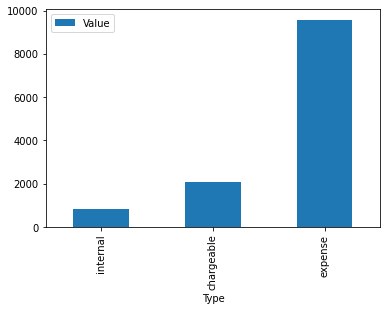

In [ ]:
grouped = df[['Type','Value']].groupby(['Type']).sum().sort_values(by='Value')
grouped.plot(kind="bar")

# Download the data as csv file

<h3>Run the following line to download the csv file version of the data that was gathered.

In [ ]:
files.download('Timesheet_Extract_' + theYear + theMonth + '.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>